## Introduction

We compare two classifiers: catboost and svm. with dimentionality reduction methods, classical, such as PCA, ICA, and linear SVD, and nature-inspired, GA. We further optimize the hyperparameters of the classifiers with PSO and ACO algorithms to determine their performance compared to the classical methods and how they might be helpful in fraud detection case.

In [2]:
# Basic data manipulation
import pandas as pd
import numpy as np
import random
import json

# Visualization
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV

# Classifiers
from catboost import CatBoostClassifier

# Additional encoders
import category_encoders as ce

# Stats
import scipy.stats as stats

# Dimensionality reduction
from sklearn.decomposition import (
    PCA,
    KernelPCA, 
    FastICA,
    TruncatedSVD
)

# PSO
from pyswarm import pso



# Data Analysis

### Dataset Overview

The IEEE-CIS Fraud Detection dataset, sourced from Kaggle, comprises 590,540 transactions, with approximately 3.5% flagged as fraudulent. It includes two main components: transaction data (e.g., amount, time, product code) and identity data (e.g., device type, email domain), linked via 'TransactionID'. The high dimensionality (over 400 features) and class imbalance make it an ideal testbed for comparing feature selection and dimensionality reduction strategies.

### 1. First and foremost, merge two dbs into one

In [2]:
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity = pd.read_csv("data/train_identity.csv")

# Merge both dataframes on 'TransactionID'
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")

print(f"Rows in merged training set: {train.shape[0]}")
print(f"Columns in merged training set: {train.shape[1]}")
train.head()

Rows in merged training set: 590540
Columns in merged training set: 434


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### 2. Download testing data

In [ ]:
test_identity = pd.read_csv("data/test_identity.csv")
test_transaction = pd.read_csv("data/test_transaction.csv")
test = pd.merge(test_transaction, test_identity, on="TransactionID", how="left")

In [ ]:
test.columns = test.columns.str.replace('-', '_')

### 3. Perform an initial exploratory data analysis (EDA) by checking missing value percentages and examining the target distribution.

In [ ]:
# To make pandas show full output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Missing value percentages per column
missing_percent = (train.isnull().sum() / len(train)) * 100
missing_percent = missing_percent.sort_values(ascending=False)
print("Missing percentages per column:")
print(missing_percent[missing_percent > 0])

In [ ]:
# Distribution of the target variable 'isFraud'
train['isFraud'].value_counts().plot(kind='bar')
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

In [ ]:
# Columns where number of nulls exceeds 90%
null_cols = [col for col in train.columns if train[col].isna().sum() > 0.9 * len(train)]
null_cols

In [ ]:
# Find correlations between columns with nulls and target
missing_df = train.copy(deep=True)
for col in null_cols:
    missing_df["m_flag_"+col] = np.where(missing_df[col].isnull(), 1, 0)
    correlation = missing_df[["m_flag_"+col, 'isFraud']].corr()
    print(correlation)


Only correlation with D7 exceeds 0.1, others are not really sufficient

### 4. Identify categorical values

In [ ]:
categorical_features = train.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    print(col, len(set(train[col])), set(train[col]))

We can see that some features (id_30, id_31, id_33, DeviceInfo) have a lot of different values that makes encoding harder

#### Find truly categorical values

Screen resolution values are true numerical values, while all other features are categorical in nature

In [ ]:
# Split column id_33 to Width and Height
train[['Screen_Width', 'Screen_Height']] = train['id_33'].str.split('x', expand=True).astype(float)
train = train.drop(columns=['id_33'])

In [ ]:
test[['Screen_Width', 'Screen_Height']] = test['id_33'].str.split('x', expand=True).astype(float)
test = test.drop(columns=['id_33'])

#### Some columns have integer type, but they categorical in nature, since they have too few distinct values, we need to identify it as categorical features

In [ ]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns

# Identify candidate categorical features based on unique value counts
candidate_categorical = {}
# Set a threshold for maximum unique values
unique_threshold = 20

# Iterate over numeric columns to check unique value counts
for col in train.select_dtypes(include=['int64', 'float64']).columns:
    unique_vals = train[col].nunique()
    if (unique_vals < unique_threshold) and (col != "isFraud"):
        candidate_categorical[col] = unique_vals

# Print candidate categorical features
print("Candidate categorical features (numeric columns with few unique values):")
for col, count in candidate_categorical.items():
    print(f"{col}: {count} unique values")

# Data Preprocessing

### 1. Imputing nulls

We want to leave as much features as possible, so Genetic Algorithm will select the most valuable ones. Therefore, we need smart imputation

Not using standard imputation:
1. Placed zero values as indicator for missing values where feature values no zero values anywhere else
2. Added 'missing' instead of null for categorical values to keep all the columns

In [ ]:
# Identify numeric and categorical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = list(set(cat_cols).union(set(candidate_categorical.keys()))) # Union of categorical values with numeric ones that actually caegorical
num_cols = [col for col in num_cols if col not in cat_cols and col not in ("TransactionID", "isFraud")]

# Imputation for numeric columns using zeros as indicator
num_imputer = SimpleImputer(strategy='constant', fill_value=0)
train[num_cols] = num_imputer.fit_transform(train[num_cols])

# Imputation for categorical columns using a constant value
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

# Confirm that no missing values remain (or check overall missing count)
print("Total missing values after imputation:", train.isnull().sum().sum())

In [ ]:
test[num_cols] = num_imputer.transform(test[num_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])
print("Total missing values after imputation:", train.isnull().sum().sum())

### 2. Data encoding

In [ ]:
X = train.drop(columns=["isFraud", "TransactionID"])
y = train['isFraud']

Splitting train and validation asap

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Encoding categorical features

Using novel thing: WOE encoder to compensate for an enormous dimentionality for SVC

In [ ]:
encoder_high = ce.WOEEncoder(cols=cat_cols)
X_train_encoded_cat = encoder_high.fit_transform(X_train[cat_cols], y_train)
X_val_encoded_cat = encoder_high.transform(X_val[cat_cols])

In [ ]:
test_encoded_cat = encoder_high.transform(test[cat_cols])

### 3. Data normalization

Scale data to remove any disrepancies in SVC

In [ ]:
X_train_for_scaling = pd.DataFrame(np.hstack([X_train_encoded_cat, X_train[num_cols]]), columns=cat_cols + num_cols)
X_val_for_scaling = pd.DataFrame(np.hstack([X_val_encoded_cat, X_val[num_cols]]), columns=cat_cols + num_cols)
test_for_scaling = pd.DataFrame(np.hstack([test_encoded_cat, test[num_cols]]), columns=cat_cols + num_cols)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_for_scaling)
X_val_scaled = scaler.transform(X_val_for_scaling)

In [ ]:
test_scaled = scaler.transform(test_for_scaling)

In [ ]:
print("Encoded training set shape:", X_train_scaled.shape)
print("Encoded validation set shape:", X_val_scaled.shape)

In [ ]:
print("Encoded test set shape:", test_scaled.shape)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cat_cols + num_cols)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=cat_cols + num_cols)
test_scaled = pd.DataFrame(test_scaled, columns=cat_cols + num_cols)

In [ ]:
X_train_scaled.head()

In [ ]:
test_scaled = pd.DataFrame(np.hstack([test[["TransactionID"]], test_scaled]), columns=["TransactionID"] + list(test_scaled.columns))
test_scaled.head()

### 4. Save data

In [ ]:
X_train_scaled.to_csv("data/preprocessed_train.csv", index=False)
X_val_scaled.to_csv("data/preprocessed_val.csv", index=False)

y_train.to_csv("data/y_train.csv", index=False)
y_val.to_csv("data/y_val.csv", index=False)

In [ ]:
test_scaled.to_csv("data/test_for_model_eval.csv", index=False)

# Baseline SVM

At first, we start with baseline - SVM with preselected features.

We will try different approaches for reducing dimensionality in dataset to compare it with GA:
- PCA - Principal Component Analysis
- ICA - Independent Component Analysis
- Truncated SVD - Truncated Singular Value Decomposition

### 1. Data stuff

In [19]:
# Download data
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_val_scaled = pd.read_csv("data/preprocessed_val.csv")
y_train = pd.read_csv("data/y_train.csv")
y_val = pd.read_csv("data/y_val.csv")

In [20]:
X_test = pd.read_csv('data/test_for_model_eval.csv')

In [21]:
transaction_ids = X_test["TransactionID"].astype(int)
X_test = X_test.drop(columns=["TransactionID"])

In [22]:
y_train_flat = y_train.values.ravel()
y_val_flat = y_val.values.ravel()

In [23]:
# Account for class imbalance
# Convert y_train to numpy array (since it's read as DataFrame)
y_train_array = y_train['isFraud'].values

# Get unique classes and compute weights
unique_classes = np.unique(y_train_array)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=y_train_array
)

# Create dictionary of class weights
class_weights_dict = dict(zip(unique_classes, class_weights))
class_weights_dict = {int(k): float(v) for k, v in class_weights_dict.items()}

### 2. PCA

In [9]:
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test)

#### Train model after PCA

In [10]:
# Define model with default hyperparameters
model_svm_pca = LinearSVC(class_weight=class_weights_dict) # Since we have huge dataset we cannot use normal SVC
clf_pca = CalibratedClassifierCV(model_svm_pca) # Since SVM by default cannot predict probabilities, we enhance it with classifier
clf_pca.fit(X_train_pca, y_train_flat)
y_pred_svm_pca = clf_pca.predict_proba(X_val_pca)[:, 1]
print("SVM after PCA Training ROC AUC:", roc_auc_score(y_val_flat, y_pred_svm_pca))

SVM after PCA Training ROC AUC: 0.8126497150275389


#### Save result to test it in Kaggle

In [11]:
y_pred_svm_pca_test = clf_pca.predict_proba(X_test_pca)
fraud_probs = y_pred_svm_pca_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_pca.csv', index=False)

#### Kaggle result:
Score: 0.837181

Private score: 0.798548
#### Validation ROC AUC: 0.8126497150275389

### 3. ICA

In [12]:
ica = FastICA(n_components=30, random_state=42)
X_train_ica= ica.fit_transform(X_train_scaled)
X_val_ica = ica.transform(X_val_scaled)
X_test_ica = ica.transform(X_test)

/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


#### Train model after ICA

In [13]:
# Define model with default hyperparameters
model_svm_ica = LinearSVC(class_weight=class_weights_dict) # Since we have huge dataset we cannot use normal SVC
clf_ica = CalibratedClassifierCV(model_svm_ica) # Since SVM by default cannot predict probabilities, we enhance it with classifier
clf_ica.fit(X_train_ica, y_train_flat)
y_pred_svm_ica = clf_ica.predict_proba(X_val_ica)[:, 1]
print("SVM after ICA Training ROC AUC:", roc_auc_score(y_val_flat, y_pred_svm_ica))

SVM after ICA Training ROC AUC: 0.812649836031573


#### Save result to test it in Kaggle

In [14]:
y_pred_svm_ica_test = clf_ica.predict_proba(X_test_ica)
fraud_probs = y_pred_svm_ica_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_ica.csv', index=False)

#### Kaggle results:

Score: 0.837181

Private score: 0.798548

#### Validation ROC AUC: 0.812649836031573

### 4. SVD

In [15]:
svd = TruncatedSVD(n_components=30, random_state=42)
X_train_svd = svd.fit_transform(X_train_scaled)
X_val_svd = svd.transform(X_val_scaled)
X_test_svd = svd.transform(X_test)

#### Train model after SVD

In [16]:
# Define model with default hyperparameters
model_svm_svd = LinearSVC(class_weight=class_weights_dict) # Since we have huge dataset we cannot use normal SVC
clf_svd = CalibratedClassifierCV(model_svm_svd) # Since SVM by default cannot predict probabilities, we enhance it with classifier
clf_svd.fit(X_train_svd, y_train_flat)
y_pred_svm_svd = clf_svd.predict_proba(X_val_svd)[:, 1]
print("SVM after ICA Training ROC AUC:", roc_auc_score(y_val_flat, y_pred_svm_svd))

SVM after ICA Training ROC AUC: 0.8126868972320699


#### Save results to test it in Kaggle

In [17]:
y_pred_svm_svd_test = clf_svd.predict_proba(X_test_svd)
fraud_probs = y_pred_svm_svd_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_svd.csv', index=False)

#### Kaggle results: 

Score: 0.837300

Private score: 0.798838

#### Validation ROC AUC: 0.8126868972320699

# Genetic Algorithm with SVM

In [18]:
def run_genetic_algorithm(X_data, y_data, population_size=30, n_generations=30, subset_size=30):
    n_features = X_data.shape[1]
    feature_names = X_data.columns.tolist()
    
    # Initialize population - each individual is a sorted list of feature indices
    # Each individual represents a potential feature subset, encoded as sorted indices for consistency
    population = []
    for _ in range(population_size):
        subset = random.sample(range(n_features), subset_size) # Randomly select 'subset_size' features from total
        subset.sort() # Sorting ensures reproducibility and simplifies comparison
        population.append(subset)
    
    def fitness(individual):
        # Extract the selected features from the dataset
        X_subset = X_data.iloc[:, individual]
        
        # Perform a single train/validation split (stratified to preserve class imbalance)
        X_train_subset, X_val_subset, y_train_subset, y_val_subset = train_test_split(
            X_subset, y_data, test_size=0.2, random_state=42, stratify=y_data
        )
        
        try:
            # Use LinearSVC with class weights to handle imbalance, wrapped in CalibratedClassifierCV for probability outputs
            base_model = LinearSVC(class_weight=class_weights_dict)
            model = CalibratedClassifierCV(base_model)
            
            # Simple fit without evaluation set or early stopping
            model.fit(X_train_subset, y_train_subset)
            
            # Get validation roc auc for imbalanced data
            roc_auc = roc_auc_score(y_val_subset, model.predict_proba(X_val_subset)[:, 1])
            print(f"Feature subset evaluated: ROC AUC = {roc_auc:.4f}")
            return roc_auc
            
        except Exception as e:
            print(f"Error in fitness evaluation: {e}")
            return 0.0  # Return worst fitness on error
    
    # Creates a child by merging features from both parents and selecting a random subset
    def crossover(p1, p2, subset_size):
        combined = list(set(p1) | set(p2))  # Union of features
        if len(combined) > subset_size:
            child = sorted(random.sample(combined, subset_size))  # Ensure correct size
        else:
            child = sorted(combined)  # Keep all if below subset_size
        return child

    # Mutation replaces a random index in child if random.threshold is met
    def mutation(individual, n_features, subset_size):
        if random.random() < 0.1:  # 10% chance of mutation
            i = random.randrange(subset_size)
            available_features = set(range(n_features)) - set(individual)  # Exclude existing features
            if available_features:  
                new_feature = random.choice(list(available_features))
                individual[i] = new_feature
                individual.sort()
        return individual

    # GA evolution loop
    # Iteratively evolve the population through selection, crossover, and mutation to optimize feature subset
    for i in range(n_generations):
        print(f"\nGeneration {i+1}/{n_generations}")
        # Evaluate fitness of population
        print("Evaluating fitness for each individual:")
        scored_population = []
        for idx, ind in enumerate(population):
            fitness_score = fitness(ind)
            scored_population.append((fitness_score, ind))
            print(f"Individual {idx+1}/{len(population)}: Fitness = {fitness_score:.4f}")
        
        scored_population.sort(key=lambda x: x[0], reverse=True)
        best_subset = scored_population[0][1]
        print(f"\nBest fitness in generation {i+1}: {scored_population[0][0]:.4f}")
        print("Current best features:", [feature_names[i] for i in best_subset])
        
        # Selection: truncation selection (pick top half as survivors)
        survivors = scored_population[: population_size // 2]
        
        # Then randomly select two parents (p1 & p2) from survivors for crossover + mutation
        print("Creating new population...")
        new_pop = [s[1] for s in survivors]
        while len(new_pop) < population_size:
            print("Generating new individual...")
            
            p1 = random.choice(survivors)[1]
            p2 = random.choice(survivors)[1]
            child = crossover(p1, p2, subset_size)
            child = mutation(child, n_features, subset_size)
            
            child = list(set(child))  # remove duplicates if any
            while len(child) < subset_size:  # if duplicates reduced size
                child.append(random.randrange(n_features))
            child.sort()
            new_pop.append(child)
            
            print("New individual created! Happy birthday!")
        population = new_pop
        # print("Current best:", max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1])
    
    best = max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1]
    print("\nFinal Selected Features:")
    for idx, feature_idx in enumerate(best, 1):
        print(f"{idx}. {feature_names[feature_idx]}")
    print(f"\nTotal features selected: {len(best)}")
    return best

y_train = y_train.values.ravel()
best_features = run_genetic_algorithm(X_train_scaled, y_train)


Generation 1/30
Evaluating fitness for each individual:
Feature subset evaluated: ROC AUC = 0.7973
Individual 1/30: Fitness = 0.7973
Feature subset evaluated: ROC AUC = 0.7788
Individual 2/30: Fitness = 0.7788
Feature subset evaluated: ROC AUC = 0.7928
Individual 3/30: Fitness = 0.7928
Feature subset evaluated: ROC AUC = 0.7574
Individual 4/30: Fitness = 0.7574
Feature subset evaluated: ROC AUC = 0.7723
Individual 5/30: Fitness = 0.7723
Feature subset evaluated: ROC AUC = 0.7818
Individual 6/30: Fitness = 0.7818
Feature subset evaluated: ROC AUC = 0.7770
Individual 7/30: Fitness = 0.7770
Feature subset evaluated: ROC AUC = 0.7576
Individual 8/30: Fitness = 0.7576
Feature subset evaluated: ROC AUC = 0.7713
Individual 9/30: Fitness = 0.7713
Feature subset evaluated: ROC AUC = 0.7887
Individual 10/30: Fitness = 0.7887
Feature subset evaluated: ROC AUC = 0.7890
Individual 11/30: Fitness = 0.7890
Feature subset evaluated: ROC AUC = 0.7709
Individual 12/30: Fitness = 0.7709
Feature subset e

We got:

Final Selected Features:
1. M9
2. id_27
3. V69
4. V21
5. V62
6. V42
7. V98
8. id_18
9. DeviceInfo
10. V58
11. V325
12. R_emaildomain
13. M5
14. V94
15. TransactionDT
16. TransactionAmt
17. D4
18. V87
19. V100
20. V172
21. V200
22. V226
23. V242
24. V246
25. V283
26. V307
27. V317
28. V332
29. id_01
30. id_21

Total features selected: 30


#### Save best features selected to json

In [19]:
feature_names = X_train_scaled.columns
selected_feature_names = [feature_names[i] for i in best_features]

ga_feature_mapping = {
    'indices': best_features,
    'names': selected_feature_names
}

# Export the GA feature information
with open('ga_selected_features_for_svm.json', 'w') as f:
    json.dump(ga_feature_mapping, f, indent=4)

In [20]:
# Load best features
with open('ga_selected_features_for_svm.json', 'r') as f:
    feature_mapping = json.load(f)

best_features = feature_mapping['indices']
best_feature_names = feature_mapping['names']

In [21]:
X_train_ga = X_train_scaled.iloc[:, best_features]
X_val_ga = X_val_scaled.iloc[:, best_features]
base_model = LinearSVC(class_weight=class_weights_dict)
model = CalibratedClassifierCV(base_model)
model.fit(X_train_ga, y_train)
y_pred = model.predict_proba(X_val_ga)[:, 1]
print("Final features:", best_features)
print("Model ROC AUC with selected features:", roc_auc_score(y_val, y_pred))

Final features: [3, 17, 31, 33, 47, 52, 78, 81, 98, 100, 102, 147, 149, 164, 169, 170, 196, 218, 223, 271, 292, 317, 331, 335, 368, 382, 392, 404, 412, 427]
Model ROC AUC with selected features: 0.8288159261688578


#### Save model test results to evaluate on Kaggle

In [22]:
X_test_ga = X_test.iloc[:, best_features]
y_pred_svm_ga_test = model.predict_proba(X_test_ga)
fraud_probs = y_pred_svm_ga_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_ga.csv', index=False)

#### Kaggle results: 

Score: 0.849871

Private score: 0.808483

#### Validation result: 0.8288159261688578

# Comparative Analysis: GA vs. PCA, ICA, and SVD on SVM

To benchmark the Genetic Algorithm's performance, we compare it with three dimensionality reduction techniques: PCA, ICA, and SVD. Each method was applied to reduce the feature space to 30 dimensions (or features, in GA’s case), followed by training an SVM model. Below are the Kaggle public and private leaderboard scores:

- **PCA**: Public = 0.837181, Private = 0.798548
- **ICA**: Public = 0.837181, Private = 0.798548
- **SVD**: Public = 0.837300, Private = 0.798838
- **GA**: Public = 0.849871, Private = 0.808483

GA showed slightly better score in comparing with other methods on both private and public datasets. It can be useful tool to select most appropriate features, but the big disadvantage is high computational power and significant time needed to run the algorithm.

### Performance Visualization

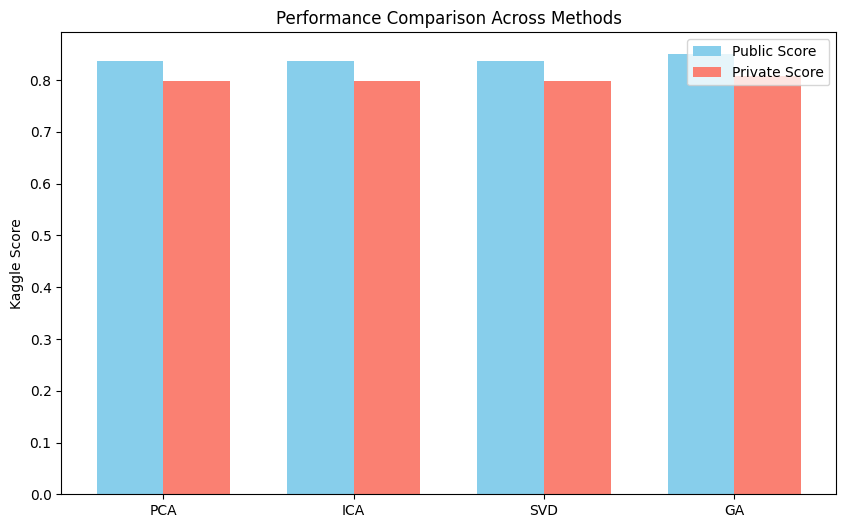

In [3]:
# Bar plot comparing methods
methods = ['PCA', 'ICA', 'SVD', 'GA']
public_scores = [0.837181, 0.837181, 0.837300, 0.849871]
private_scores = [0.798548, 0.798548, 0.798838, 0.808483]

x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, public_scores, width, label='Public Score', color='skyblue')
ax.bar(x + width/2, private_scores, width, label='Private Score', color='salmon')
ax.set_ylabel('Kaggle Score')
ax.set_title('Performance Comparison Across Methods')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
plt.show()

## Analytical Insights

**Computational Trade-offs:**

While GA showed superior performance, it comes at a significant computational cost:
- GA requires multiple generations of feature subset evaluations, which involves training and validating models repeatedly.
- In contrast, PCA, ICA, and SVD are computationally efficient as they involve matrix decompositions that are faster to compute.
- This makes GA more suitable for scenarios where computational resources and time are not a constraint, and the goal is to maximize performance.

**Feature Selection vs. Transformation:**
- GA directly selects the most relevant features, preserving their interpretability. This is particularly useful in domains like fraud detection, where understanding the importance of specific features (e.g., transaction amount, device type) is critical.
- PCA, ICA, and SVD transform the original features into new components, which can make the results less interpretable.



# PSO and ACO for SVM hyperparameter tuning

We tune all hyperpameters of SVM with PSO and ACO algorithms. We will use the same dataset as before, but reduced featured from GA to continue with fully nature-inspired approach.

## 1. PSO

In [24]:
def run_pso_for_svm_hyperparams(X_train_ga, y_train, X_test_ga, y_test, n_particles=10, n_iterations=5):
    """
    Runs Particle Swarm Optimization (PSO) to find optimal hyperparameters for LinearSVC.

    Args:
        X_train_ga: Training features selected by GA.
        y_train: Training target variable (flattened if needed).
        X_test_ga: Testing features selected by GA.
        y_test: Testing target variable (flattened if needed).
        n_particles: Number of particles in the swarm.
        n_iterations: Number of iterations for PSO.

    Returns:
        tuple: (best_params_dict, best_score)
               - best_params_dict: Dictionary containing the best hyperparameter set found.
               - best_score: The best AUC score achieved by PSO.
    """
    print(f"Starting PSO with {n_particles} particles and {n_iterations} iterations...")

    # Flatten y_train and y_test if needed
    y_train = y_train.values.ravel() if len(y_train.shape) > 1 else y_train
    y_test = y_test.values.ravel() if len(y_test.shape) > 1 else y_test

    # Define parameter bounds for PSO
    param_bounds_pso = {
        'C': (0.001, 100.0),          # params[0] Regularization parameter
        'max_iter': (100, 5000),      # params[1] Integer, maximum iterations
    }
    param_keys = list(param_bounds_pso.keys())

    # Define the objective function for PSO
    def objective_function_pso(params):
        C = params[param_keys.index('C')]
        max_iter = int(round(params[param_keys.index('max_iter')]))

        svm_params = {
            'C': C,
            'max_iter': max_iter,
            'random_state': 42
        }

        try:
            # Use CalibratedClassifierCV to get probabilities
            base_model = LinearSVC(**svm_params, class_weight=class_weights_dict)
            model = CalibratedClassifierCV(base_model)
            model.fit(X_train_ga, y_train)
            y_pred = model.predict_proba(X_test_ga)[:, 1]
            auc = roc_auc_score(y_test, y_pred)
        except Exception as e:
            print(f"Warning: Exception during SVM training/evaluation: {e}")
            print(f"Params causing issue: {svm_params}")
            auc = 0.0
        return auc

    # Extract bounds for pyswarm
    lb = [param_bounds_pso[k][0] for k in param_keys]
    ub = [param_bounds_pso[k][1] for k in param_keys]

    # Run PSO
    best_params_pso_vals, best_score_pso = pso(objective_function_pso, lb, ub, swarmsize=n_particles, maxiter=n_iterations)

    # Process results
    best_params_pso_dict = {
        'C': best_params_pso_vals[param_keys.index('C')],
        'max_iter': int(round(best_params_pso_vals[param_keys.index('max_iter')]))
    }

    print("-" * 30)
    print("PSO Finished.")
    print(f"Best ROC AUC score found by PSO: {best_score_pso:.6f}")
    print("Best SVM Parameters:")
    for key, val in best_params_pso_dict.items():
        print(f"  {key}: {val}")
    print("-" * 30)

    return best_params_pso_dict, best_score_pso

In [25]:
X_train_ga = X_train_scaled.iloc[:, best_features]
X_val_ga = X_val_scaled.iloc[:, best_features]
X_test_ga = X_test.iloc[:, best_features]

# Run PSO
best_params_pso, best_score_pso = run_pso_for_svm_hyperparams(X_train_ga, y_train, X_val_ga, y_val, n_particles=10, n_iterations=20)

# Train final model with best parameters
final_model = CalibratedClassifierCV(LinearSVC(**best_params_pso, class_weight=class_weights_dict))
final_model.fit(X_train_ga, y_train.ravel())
y_pred = final_model.predict_proba(X_val_ga)[:, 1]
acc = roc_auc_score(y_val, y_pred)
print(f"Final ROC AUC with optimized SVM: {acc:.6f}")

Starting PSO with 10 particles and 20 iterations...
Stopping search: maximum iterations reached --> 20
------------------------------
PSO Finished.
Best ROC AUC score found by PSO: 0.828657
Best SVM Parameters:
  C: 0.001
  max_iter: 5000
------------------------------
Final ROC AUC with optimized SVM: 0.828657


We got:

PSO Finished.

Best ROC AUC score found by PSO: 0.828657

Best SVM Parameters:
  - C: 0.001
  - max_iter: 5000
------------------------------
Final ROC AUC with optimized SVM: 0.828657

#### Save results to file

In [26]:
X_test_pso = X_test.iloc[:, best_features]
y_pred_svm_pso_test = final_model.predict_proba(X_test_pso)
fraud_probs = y_pred_svm_pso_test[:, 1]

submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_ga_pso.csv', index=False)

#### Kaggle results: 

Score: 0.849987
Private score: 0.808601

#### Validation result: 0.828657

## 2. ACO

In [27]:
class ACO_HyperparameterOptimizer:
    def __init__(self, param_grid, objective_function, n_ants, n_iterations,
                 alpha=1.0, beta=1.0, rho=0.1, Q=1.0, min_pheromone=0.01):
        self.param_grid = param_grid
        self.objective_function = objective_function
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        self.min_pheromone = min_pheromone
        self.param_names = list(self.param_grid.keys())
        self.pheromones = self._initialize_pheromones()
        self.global_best_score = -np.inf
        self.global_best_params = None

    def _initialize_pheromones(self):
        pheromones = {}
        initial_pheromone = 1.0
        for param, values in self.param_grid.items():
            pheromones[param] = {value: initial_pheromone for value in values}
        return pheromones

    def _select_next_node(self, param_name):
        pheromone_values = self.pheromones[param_name]
        choices = list(pheromone_values.keys())
        current_pheromones = np.array([pheromone_values[choice] for choice in choices])
        selection_probs = current_pheromones ** self.alpha
        prob_sum = np.sum(selection_probs)
        if prob_sum == 0:
            selection_probs = np.ones(len(choices)) / len(choices)
        else:
            selection_probs = selection_probs / prob_sum
        chosen_value = np.random.choice(choices, p=selection_probs)
        return chosen_value

    def _construct_solution(self):
        solution = {}
        for param_name in self.param_names:
            solution[param_name] = self._select_next_node(param_name)
        return solution

    def _update_pheromones(self, ant_solutions, ant_scores):
        # Evaporation
        for param_name, values in self.pheromones.items():
            for value in values:
                self.pheromones[param_name][value] *= (1.0 - self.rho)
                self.pheromones[param_name][value] = max(self.pheromones[param_name][value], self.min_pheromone)
        
        # Deposition
        for i in range(self.n_ants):
            solution = ant_solutions[i]
            score = ant_scores[i]
            if score > -np.inf:
                delta_pheromone = self.Q * score
                for param_name, value in solution.items():
                    if param_name in self.pheromones and value in self.pheromones[param_name]:
                        self.pheromones[param_name][value] += delta_pheromone
                    else:
                        print(f"Warning: Skipping update for {param_name}={value} - not in pheromone trails")

    def run(self):
        print(f"Starting ACO: {self.n_iterations} iterations, {self.n_ants} ants/iteration.")
        for iteration in range(self.n_iterations):
            ant_solutions = []
            ant_scores = []
            for ant in range(self.n_ants):
                solution = self._construct_solution()
                try:
                    score = self.objective_function(solution.copy())
                    if score is None or not np.isfinite(score):
                        score = -np.inf
                except Exception as e:
                    print(f"Error evaluating solution: {solution}")
                    print(f"Exception: {e}")
                    score = -np.inf
                ant_solutions.append(solution)
                ant_scores.append(score)
                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_params = solution
                    print(f"Iteration {iteration+1}, Ant {ant+1}: New best score! -> {self.global_best_score:.6f}")
            self._update_pheromones(ant_solutions, ant_scores)
            avg_score = np.mean([s for s in ant_scores if s > -np.inf]) if any(s > -np.inf for s in ant_scores) else -np.inf
            print(f"Iteration {iteration+1}/{self.n_iterations} finished. Avg Score: {avg_score:.6f}. Best Score so far: {self.global_best_score:.6f}")
        print("-" * 30)
        print("ACO Finished.")
        if self.global_best_params:
            print(f"Best score found: {self.global_best_score:.6f}")
            print("Best parameters found:")
            for param, value in self.global_best_params.items():
                print(f"  {param}: {value}")
        else:
            print("No valid solution found.")
        return self.global_best_params, self.global_best_score

def run_aco_for_svm_hyperparams(X_train_ga, y_train, X_test_ga, y_test,
                                n_ants=10, n_iterations=5,
                                alpha=1.0, beta=1.0, rho=0.1, Q=1.0):
    # Flatten y_train and y_test if needed
    y_train = y_train.values.ravel() if len(y_train.shape) > 1 else y_train
    y_test = y_test.values.ravel() if len(y_test.shape) > 1 else y_test

    # Define parameter grid for ACO
    param_grid_aco = {
        'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [100, 500, 1000, 2000, 5000]
    }

    # Define objective function for ACO
    def objective_function_aco(params):
        svm_params = params.copy()
        try:
            base_model = LinearSVC(**svm_params, class_weight=class_weights_dict)
            model = CalibratedClassifierCV(base_model)
            model.fit(X_train_ga, y_train)
            y_pred = model.predict_proba(X_test_ga)[:, 1]
            auc = roc_auc_score(y_test, y_pred)
            if not np.isfinite(auc):
                auc = 0.0
        except Exception as e:
            print(f"Error in objective function: {e}")
            auc = 0.0
        return auc

    # Instantiate and run ACO
    aco_optimizer = ACO_HyperparameterOptimizer(
        param_grid=param_grid_aco,
        objective_function=objective_function_aco,
        n_ants=n_ants,
        n_iterations=n_iterations,
        alpha=alpha,
        beta=beta,
        rho=rho,
        Q=Q
    )

    best_params_aco, best_score_aco = aco_optimizer.run()
    return best_params_aco, best_score_aco

In [28]:
best_params_aco, best_score_aco = run_aco_for_svm_hyperparams(X_train_ga, y_train, X_val_ga, y_val, n_ants=10, n_iterations=20)

# Train final model with best parameters
final_model = CalibratedClassifierCV(LinearSVC(**best_params_aco, random_state=42), cv=3)
final_model.fit(X_train_ga, y_train.ravel())
y_pred = final_model.predict_proba(X_val_ga)[:, 1]
acc = roc_auc_score(y_val, y_pred)
print(f"Final ROC AUC with optimized SVM: {acc:.6f}")

Starting ACO: 20 iterations, 10 ants/iteration.
Iteration 1, Ant 1: New best score! -> 0.828816
Iteration 1/20 finished. Avg Score: 0.828800. Best Score so far: 0.828816
Iteration 2/20 finished. Avg Score: 0.828783. Best Score so far: 0.828816
Iteration 3/20 finished. Avg Score: 0.828810. Best Score so far: 0.828816
Iteration 4/20 finished. Avg Score: 0.828814. Best Score so far: 0.828816
Iteration 5/20 finished. Avg Score: 0.828797. Best Score so far: 0.828816
Iteration 6/20 finished. Avg Score: 0.828816. Best Score so far: 0.828816
Iteration 7/20 finished. Avg Score: 0.828797. Best Score so far: 0.828816
Iteration 8/20 finished. Avg Score: 0.828781. Best Score so far: 0.828816
Iteration 9/20 finished. Avg Score: 0.828798. Best Score so far: 0.828816
Iteration 10/20 finished. Avg Score: 0.828813. Best Score so far: 0.828816
Iteration 11/20 finished. Avg Score: 0.828797. Best Score so far: 0.828816
Iteration 12/20 finished. Avg Score: 0.828798. Best Score so far: 0.828816
Iteration 13/

We got:

ACO Finished.

Best score found: 0.828816

Best parameters found:
  - C: 100.0
  - max_iter: 500
  
Final ROC AUC with optimized SVM: 0.803286

#### Save test results to file

In [ ]:
X_test_aco = X_test.iloc[:, best_features]
y_pred_svm_aco_test = final_model.predict_proba(X_test_aco)
fraud_probs = y_pred_svm_aco_test[:, 1]

submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_ga_aco.csv', index=False)

#### Kaggle results: 

Score: 0.826630
Private score: 0.780363

#### Validation result: 0.803286

# Analysis of results for SVM

**GA + PSO:**

Validation ROC AUC: 0.828657
Kaggle Public Score: 0.849987
Kaggle Private Score: 0.808601
PSO demonstrated a slight improvement over the baseline SVM with GA-selected features. The optimization of hyperparameters using PSO allowed the model to better generalize, as reflected in the Kaggle scores.

**GA + ACO:**

Validation ROC AUC: 0.828816
Kaggle Public Score: 0.826630
Kaggle Private Score: 0.780363
ACO achieved a similar validation ROC AUC to PSO but underperformed on the Kaggle leaderboard. This suggests that ACO's hyperparameter tuning may have led to overfitting on the validation set.

It does pretty well, but we are not sure if linear approach is the best one for this dataset. We will try to use CatBoost classifier to see if it can outperform SVM. + In CatBoost there are a lot more hyperparameters to tune, so PSO and ACO can show some significant results here.

# Baseline catboost

Since SVM did not show any significant improvements with nature-inspired algorithms, we decided to test CatBoostClassifier with these algorithms. CatBoost has much more hyperparameters for tuning, so PSO and ACO can show improvements here.

## 1. Download processed data

In [10]:
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_val_scaled = pd.read_csv("data/preprocessed_val.csv")
y_train = pd.read_csv("data/y_train.csv")
y_val = pd.read_csv("data/y_val.csv")

X_test = pd.read_csv("data/test_for_model_eval.csv")
X_test = X_test.drop(columns=["TransactionID"])

In [11]:
y_train_flat = y_train.values.ravel()
y_val_flat = y_val.values.ravel()

Accounting for severe class imbalance

In [12]:
# Convert y_train to numpy array (since it's read as DataFrame)
y_train_array = y_train['isFraud'].values

# Get unique classes and compute weights
unique_classes = np.unique(y_train_array)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=y_train_array
)

# Create dictionary of class weights
class_weights_dict = dict(zip(unique_classes, class_weights))
class_weights_dict = {int(k): float(v) for k, v in class_weights_dict.items()}

## 2. PCA

In [33]:
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test)

#### Train baseline model

In [34]:
model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights_dict,
    random_seed=42,
    verbose=100
)
model_cat.fit(X_train_pca, y_train_flat)
y_pred_cat = model_cat.predict_proba(X_val_pca)[:, 1]

print("CatBoost Validation ROC AUC:", roc_auc_score(y_val_flat, y_pred_cat))

0:	learn: 0.6599149	total: 92.8ms	remaining: 46.3s
100:	learn: 0.4532001	total: 2.21s	remaining: 8.73s
200:	learn: 0.4251124	total: 4.3s	remaining: 6.39s
300:	learn: 0.4037742	total: 6.54s	remaining: 4.32s
400:	learn: 0.3869200	total: 8.72s	remaining: 2.15s
499:	learn: 0.3725436	total: 10.8s	remaining: 0us
CatBoost Validation ROC AUC: 0.8802487906628617


#### Save model results

In [35]:
y_pred_cbm_pca_test = final_model.predict_proba(X_test_pca)
fraud_probs = y_pred_cbm_pca_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/cbm_pca.csv', index=False)

/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


#### Kaggle results:

Score: 0.363070
Private score: 0.364691

#### Validation result: 0.8802487906628617

## 3. ICA

In [36]:
ica = FastICA(n_components=30, random_state=42)
X_train_ica = ica.fit_transform(X_train_scaled)
X_val_ica = ica.transform(X_val_scaled)
X_test_ica = ica.transform(X_test)

/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


#### Train baseline model

In [37]:
model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights_dict,
    random_seed=42,
    verbose=100
)
model_cat.fit(X_train_ica, y_train_flat)
y_pred_cat = model_cat.predict(X_val_ica)

print("CatBoost Training ROC AUC:", roc_auc_score(y_val_flat, y_pred_cat))

0:	learn: 0.6609505	total: 38.7ms	remaining: 19.3s
100:	learn: 0.4527178	total: 2.16s	remaining: 8.52s
200:	learn: 0.4200329	total: 4.27s	remaining: 6.35s
300:	learn: 0.3953672	total: 6.4s	remaining: 4.23s
400:	learn: 0.3761558	total: 8.65s	remaining: 2.13s
499:	learn: 0.3594246	total: 10.7s	remaining: 0us
CatBoost Training ROC AUC: 0.8040872381768577


#### Save model results

In [38]:
y_pred_cbm_ica_test = final_model.predict_proba(X_test_ica)
fraud_probs = y_pred_cbm_ica_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/cbm_ica.csv', index=False)

/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


#### Kaggle results: 

Score: 0.528929
Private score: 0.540807

#### Validation result: 0.8040872381768577

## 4. Truncated SVD

In [39]:
svd = TruncatedSVD(n_components=30, random_state=42)
X_train_svd = svd.fit_transform(X_train_scaled)
X_val_svd = svd.transform(X_val_scaled)
X_test_svd = svd.transform(X_test)

#### Train baseline model

In [40]:
model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights_dict,
    random_seed=42,
    verbose=100
)
model_cat.fit(X_train_svd, y_train_flat)
y_pred_cat = model_cat.predict(X_val_svd)

print("CatBoost Training ROC AUC:", roc_auc_score(y_val_flat, y_pred_cat))

0:	learn: 0.6599015	total: 21ms	remaining: 10.5s
100:	learn: 0.4535756	total: 2.13s	remaining: 8.42s
200:	learn: 0.4245948	total: 4.26s	remaining: 6.34s
300:	learn: 0.4039709	total: 6.37s	remaining: 4.21s
400:	learn: 0.3871830	total: 8.5s	remaining: 2.1s
499:	learn: 0.3727525	total: 10.6s	remaining: 0us
CatBoost Training ROC AUC: 0.7955204327783582


#### Save model results

In [41]:
y_pred_cbm_svd_test = final_model.predict_proba(X_test_svd)
fraud_probs = y_pred_cbm_svd_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/cbm_svd.csv', index=False)

/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/vladislavkalinichenko/VSCodeProjects/NIC_Labs/project/github/FraudDetection/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


#### Kaggle results: 

Score: 0.363238
Private score: 0.364369

#### Validation result: 0.7955204327783582

# Genetic Algorithm for CatBoost

In [13]:
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_val_scaled = pd.read_csv("data/preprocessed_val.csv")
y_train = pd.read_csv("data/y_train.csv")
y_val = pd.read_csv("data/y_val.csv")

In [43]:
def run_genetic_algorithm(X_data, y_data, population_size=30, n_generations=30, subset_size=30):
    n_features = X_data.shape[1]
    feature_names = X_data.columns.tolist()
    
    # Initialize population - each individual is a sorted list of feature indices
    population = []
    for _ in range(population_size):
        subset = random.sample(range(n_features), subset_size)
        subset.sort()
        population.append(subset)
    
    def fitness(individual):
        X_subset = X_data.iloc[:, individual]
        
        # Manual train/test split instead of cross-validation
        X_train_subset, X_val_subset, y_train_subset, y_val_subset = train_test_split(
            X_subset, y_data, test_size=0.2, random_state=42, stratify=y_data
        )
        
        try:
            model = CatBoostClassifier(
                iterations=100,  # Reduce from 500 to speed up GA
                learning_rate=0.1,
                depth=6,
                class_weights=class_weights_dict,
                random_seed=42,
                verbose=0        # Turn off verbosity completely            
            )
            
            # Use a simple fit instead of cross_val_score
            model.fit(X_train_subset, y_train_subset, 
                     eval_set=(X_val_subset, y_val_subset),
                     early_stopping_rounds=20,
                     verbose=False)
            
            # Get validation ROC AUC
            auc = roc_auc_score(y_val_subset, model.predict_proba(X_val_subset)[:, 1])
            print(f"Feature subset evaluated: roc_auc = {auc:.4f}")
            return auc
            
        except Exception as e:
            print(f"Error in fitness evaluation: {e}")
            return 0.0  # Return worst fitness on error
    
    # Creates a child by merging features from both parents and selecting a random subset
    def crossover(p1, p2, subset_size):
        combined = list(set(p1) | set(p2))  # Union of features
        if len(combined) > subset_size:
            child = sorted(random.sample(combined, subset_size))  # Ensure correct size
        else:
            child = sorted(combined)  # Keep all if below subset_size
        return child

    # Mutation replaces a random index in child if random.threshold is met
    def mutation(individual, n_features, subset_size):
        if random.random() < 0.1:  # 10% chance of mutation
            i = random.randrange(subset_size)
            available_features = set(range(n_features)) - set(individual)  # Exclude existing features
            if available_features:  
                new_feature = random.choice(list(available_features))
                individual[i] = new_feature
                individual.sort()
        return individual


    for i in range(n_generations):
        print(f"\nGeneration {i+1}/{n_generations}")
        # Evaluate fitness of population
        print("Evaluating fitness for each individual:")
        scored_population = []
        for idx, ind in enumerate(population):
            fitness_score = fitness(ind)
            scored_population.append((fitness_score, ind))
            print(f"Individual {idx+1}/{len(population)}: Fitness = {fitness_score:.4f}")
        
        scored_population.sort(key=lambda x: x[0], reverse=True)
        best_subset = scored_population[0][1]
        print(f"\nBest fitness in generation {i+1}: {scored_population[0][0]:.4f}")
        print("Current best features:", [feature_names[i] for i in best_subset])
        
        # Selection: truncation selection (pick top half as survivors)
        survivors = scored_population[: population_size // 2]
        
        # Then randomly select two parents (p1 & p2) from survivors for crossover + mutation
        print("Creating new population...")
        new_pop = [s[1] for s in survivors]
        while len(new_pop) < population_size:
            print("Generating new individual...")
            
            p1 = random.choice(survivors)[1]
            p2 = random.choice(survivors)[1]
            child = crossover(p1, p2, subset_size)
            child = mutation(child, n_features, subset_size)
            
            child = list(set(child))  # remove duplicates if any
            while len(child) < subset_size:  # if duplicates reduced size
                child.append(random.randrange(n_features))
            child.sort()
            new_pop.append(child)
            
            print("New individual created! Happy birthday!")
        population = new_pop
        #print("Current best:", max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1])
    
    best = max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1]
    print("\nFinal Selected Features:")
    for idx, feature_idx in enumerate(best, 1):
        print(f"{idx}. {feature_names[feature_idx]}")
    print(f"\nTotal features selected: {len(best)}")
    return best

best_features = run_genetic_algorithm(X_train_scaled, y_train)


Generation 1/30
Evaluating fitness for each individual:
Feature subset evaluated: roc_auc = 0.8441
Individual 1/30: Fitness = 0.8441
Feature subset evaluated: roc_auc = 0.8276
Individual 2/30: Fitness = 0.8276
Feature subset evaluated: roc_auc = 0.8202
Individual 3/30: Fitness = 0.8202
Feature subset evaluated: roc_auc = 0.8473
Individual 4/30: Fitness = 0.8473
Feature subset evaluated: roc_auc = 0.8492
Individual 5/30: Fitness = 0.8492
Feature subset evaluated: roc_auc = 0.8373
Individual 6/30: Fitness = 0.8373
Feature subset evaluated: roc_auc = 0.8399
Individual 7/30: Fitness = 0.8399
Feature subset evaluated: roc_auc = 0.8491
Individual 8/30: Fitness = 0.8491
Feature subset evaluated: roc_auc = 0.8542
Individual 9/30: Fitness = 0.8542
Feature subset evaluated: roc_auc = 0.8480
Individual 10/30: Fitness = 0.8480
Feature subset evaluated: roc_auc = 0.8594
Individual 11/30: Fitness = 0.8594
Feature subset evaluated: roc_auc = 0.8375
Individual 12/30: Fitness = 0.8375
Feature subset e

NameError: name 'X_test_scaled' is not defined

We got:

Final Selected Features:
1. M6
2. V250
3. V284
4. V70
5. id_18
6. V73
7. V5
8. V54
9. V90
10. V107
11. V109
12. V51
13. card2
14. addr1
15. C1
16. C2
17. C3
18. C11
19. C13
20. C14
21. D1
22. V56
23. V127
24. V163
25. V177
26. V253
27. V258
28. V264
29. V283
30. V287

Total features selected: 30

#### Save best features selected to json

In [44]:
feature_names = X_train_scaled.columns
selected_feature_names = [feature_names[i] for i in best_features]

ga_feature_mapping = {
    'indices': best_features,
    'names': selected_feature_names
}

# Export the GA feature information
with open('ga_selected_features_for_catboost.json', 'w') as f:
    json.dump(ga_feature_mapping, f, indent=4)

In [45]:
# Load best features
with open('ga_selected_features_for_catboost.json', 'r') as f:
    feature_mapping = json.load(f)

best_features = feature_mapping['indices']
best_feature_names = feature_mapping['names']

In [17]:
best_features = [23, 30, 35, 56, 81, 91, 93, 101, 110, 123, 162, 167, 172, 175, 179, 180, 181, 189, 191, 192, 193, 212, 230, 262, 273, 339, 344, 349, 368, 370]
X_train_ga = X_train_scaled.iloc[:, best_features]
X_val_ga = X_val_scaled.iloc[:, best_features]

In [ ]:
model = CatBoostClassifier(
            iterations=500,
            learning_rate=0.1,
            depth=6,
            class_weights=class_weights_dict,
            random_seed=42,
            verbose=100
        )

model.fit(X_train_ga, y_train)
y_pred = model.predict_proba(X_val_ga)[:, 1]
print("Final features:", best_features)
print("Model ROC AUC with selected features:", roc_auc_score(y_val, y_pred))

#### Save model test results to evaluate on Kaggle

In [ ]:
X_test_ga = X_test.iloc[:, best_features]
y_pred_catboost_ga_test = model.predict_proba(X_test_ga)
fraud_probs = y_pred_catboost_ga_test[:, 1]

submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/catboost_ga.csv', index=False)

#### Kaggle results: 

Score: 0.906293
Private score: 0.849037

#### Validation result AUC: 0.9259348901705291

# Analysis of GA results

The performance of CatBoost across different dimensionality reduction methods is summarized below:

- **PCA**: Public = 0.363070, Private = 0.364691  

- **ICA**: Public = 0.528929, Private = 0.540807  

- **SVD**: Public = 0.363238, Private = 0.364369  

- **GA**: Public = 0.906293, Private = 0.849037  

GA outperformed all other methods by a significant margin. This demonstrates the effectiveness of Genetic Algorithm in selecting the most relevant features for CatBoost. The interpretability of the selected features and their direct relevance to the target variable likely contributed to this superior performance, so CatBoost easily handeled these features to achieve target. 

Also, PCA, ICA and SVD possibly introduced more non-linearity to the model, that itself can be complex, which lead to the overfitting. GA just chose best features to achieve the target and CatBoost correctly handled it.

While GA provided the best results, it is computationally expensive compared to PCA, ICA, and SVD. This trade-off should be considered when choosing a dimensionality reduction or feature selection method.


The Genetic Algorithm is the most effective method for feature selection in this context, significantly outperforming PCA, ICA, and SVD. It highlights the importance of tailored feature selection techniques when working with advanced machine learning models like CatBoost.


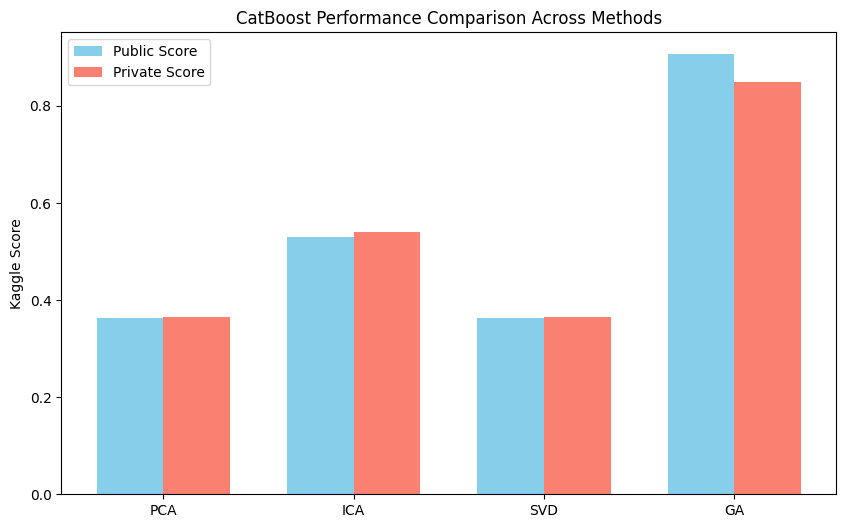

In [ ]:
# Bar plot comparing methods for CatBoost
catboost_methods = ['PCA', 'ICA', 'SVD', 'GA']
catboost_public_scores = [0.363070, 0.528929, 0.363238, 0.906293]
catboost_private_scores = [0.364691, 0.540807, 0.364369, 0.849037]

x_catboost = np.arange(len(catboost_methods))

fig_catboost, ax_catboost = plt.subplots(figsize=(10, 6))
ax_catboost.bar(x_catboost - width/2, catboost_public_scores, width, label='Public Score', color='skyblue')
ax_catboost.bar(x_catboost + width/2, catboost_private_scores, width, label='Private Score', color='salmon')
ax_catboost.set_ylabel('Kaggle Score')
ax_catboost.set_title('CatBoost Performance Comparison Across Methods')
ax_catboost.set_xticks(x_catboost)
ax_catboost.set_xticklabels(catboost_methods)
ax_catboost.legend()
plt.show()

# PSO and ACO for CatBoost hyperparameter tuning

## 1. PSO

In [ ]:
def run_pso_for_catboost_hyperparams(X_train_ga, y_train, X_test_ga, y_test, n_particles=10, n_iterations=5):
    """
    Runs Particle Swarm Optimization (PSO) to find optimal hyperparameters for CatBoost using the provided training and testing data (already filtered by GA features).

    Args:
        X_train_ga: Training features (pandas DataFrame or numpy array) selected by GA.
        y_train: Training target variable.
        X_test_ga: Testing features (pandas DataFrame or numpy array) selected by GA.
        y_test: Testing target variable.
        n_particles: Number of particles in the swarm.
        n_iterations: Number of iterations for PSO.

    Returns:
        tuple: (best_params_dict, best_score)
               - best_params_dict: Dictionary containing the best hyperparameter set found.
               - best_score: The best AUC score achieved by PSO.
    """
    print(f"Starting PSO with {n_particles} particles and {n_iterations} iterations...")

    # Mapping for categorical parameters (indices):
    grow_policy_map = ['SymmetricTree', 'Depthwise', 'Lossguide']
    bootstrap_type_map = ['Bayesian', 'Bernoulli', 'MVS']
    leaf_estimation_method_map = ['Newton', 'Gradient']
    boosting_type_map = ['Ordered', 'Plain']

    param_bounds_pso = {
        # Key order must match the order in objective_function_pso's params array
        'learning_rate': (0.01, 0.3),             # params[0]
        'depth': (3, 10),                         # params[1] Integer
        'l2_leaf_reg': (1.0, 10.0),               # params[2]
        'iterations': (100, 1000),                # params[3] Integer
        'grow_policy_idx': (0, len(grow_policy_map) - 1), # params[4] Integer index
        'max_leaves': (4, 64),                    # params[5] Integer
        'min_data_in_leaf': (1, 50),              # params[6] Integer
        'random_strength': (0.1, 5.0),            # params[7]
        'bagging_temperature': (0.0, 1.0),        # params[8]
        'bootstrap_type_idx': (0, len(bootstrap_type_map) - 1), # params[9] Integer index
        'subsample': (0.5, 1.0),                  # params[10] Used only if bootstrap_type is not Bayesian
        'rsm': (0.5, 1.0),                        # params[11] aka colsample_bylevel
        'leaf_estimation_method_idx': (0, len(leaf_estimation_method_map) - 1), # params[12] Integer index
        'leaf_estimation_iterations': (1, 10),    # params[13] Integer
        'boosting_type_idx': (0, len(boosting_type_map) - 1), # params[14] Integer index
        'one_hot_max_size': (2, 30),              # params[15] Integer
        'early_stopping_rounds': (10, 50)         # params[16] Integer, used in fit
    }

    # Ordered list of keys corresponding to the parameter order
    param_keys = list(param_bounds_pso.keys())

    # Define the objective function for PSO
    def objective_function_pso(params):
        # --- Parameter Extraction and Mapping ---
        depth = int(round(params[param_keys.index('depth')]))
        iterations = int(round(params[param_keys.index('iterations')]))
        grow_policy_idx = int(round(params[param_keys.index('grow_policy_idx')]))
        max_leaves = int(round(params[param_keys.index('max_leaves')]))
        min_data_in_leaf = int(round(params[param_keys.index('min_data_in_leaf')]))
        bootstrap_type_idx = int(round(params[param_keys.index('bootstrap_type_idx')]))
        leaf_estimation_method_idx = int(round(params[param_keys.index('leaf_estimation_method_idx')]))
        leaf_estimation_iterations = int(round(params[param_keys.index('leaf_estimation_iterations')]))
        boosting_type_idx = int(round(params[param_keys.index('boosting_type_idx')]))
        one_hot_max_size = int(round(params[param_keys.index('one_hot_max_size')]))
        early_stopping_rounds = int(round(params[param_keys.index('early_stopping_rounds')]))
        
        grow_policy = grow_policy_map[grow_policy_idx]
        bootstrap_type = bootstrap_type_map[bootstrap_type_idx]
        leaf_estimation_method = leaf_estimation_method_map[leaf_estimation_method_idx]
        boosting_type = boosting_type_map[boosting_type_idx]
        
        # --- Adjust incompatible parameters ---
        # max_leaves is valid only with Lossguide tree growing. If not Lossguide, do not include max_leaves.
        if grow_policy != "Lossguide":
            max_leaves = None
        # Ordered boosting is supported only for symmetric trees; change to Plain if needed.
        if boosting_type == "Ordered" and grow_policy != "SymmetricTree":
            boosting_type = "Plain"
        
        # --- Build CatBoost Params ---
        cb_params = {
            'learning_rate': params[param_keys.index('learning_rate')],
            'depth': depth,
            'l2_leaf_reg': params[param_keys.index('l2_leaf_reg')],
            'iterations': iterations,
            'grow_policy': grow_policy,
            **({'max_leaves': max_leaves} if max_leaves is not None else {}),
            'min_data_in_leaf': min_data_in_leaf,
            'random_strength': params[param_keys.index('random_strength')],
            'bootstrap_type': bootstrap_type,
            'rsm': params[param_keys.index('rsm')],
            'leaf_estimation_method': leaf_estimation_method,
            'leaf_estimation_iterations': leaf_estimation_iterations,
            'boosting_type': boosting_type,
            'one_hot_max_size': one_hot_max_size,
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': 0,
            'random_state': 42,
            'class_weights': class_weights_dict # For class imbalance
        }
        
        # Handle parameter dependencies for bootstrap_type
        if bootstrap_type == 'Bayesian':
            cb_params['bagging_temperature'] = params[param_keys.index('bagging_temperature')]
        elif bootstrap_type in ['Bernoulli', 'MVS']:
            cb_params['subsample'] = params[param_keys.index('subsample')]
        
        # --- Train and Evaluate ---
        model = CatBoostClassifier(**cb_params)
        try:
            model.fit(X_train_ga, y_train,
                      eval_set=(X_test_ga, y_test),
                      early_stopping_rounds=early_stopping_rounds,
                      verbose=0)
            y_pred_proba = model.predict_proba(X_test_ga)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
        except Exception as e:
            print(f"Warning: Exception during model training/evaluation: {e}")
            print(f"Params causing issue: {cb_params}")
            auc = 0.0
        return auc

    # Extract bounds for pyswarm
    lb = [param_bounds_pso[k][0] for k in param_keys]
    ub = [param_bounds_pso[k][1] for k in param_keys]

    # Run PSO
    best_params_pso_vals, best_score_pso = pso(objective_function_pso, lb, ub, swarmsize=n_particles, maxiter=n_iterations)

    # --- Process Results ---
    # Map best_params_pso_vals back to dictionary
    best_params_pso_dict = {}
    for i, key in enumerate(param_keys):
        val = best_params_pso_vals[i]
        if key in ['depth', 'iterations', 'grow_policy_idx', 'max_leaves', 'min_data_in_leaf',
                   'bootstrap_type_idx', 'leaf_estimation_method_idx', 'leaf_estimation_iterations',
                   'boosting_type_idx', 'one_hot_max_size', 'early_stopping_rounds']:
            best_params_pso_dict[key] = int(round(val))
        else:
            best_params_pso_dict[key] = val

    # Map indices back for categorical features
    best_params_pso_dict['grow_policy'] = grow_policy_map[best_params_pso_dict['grow_policy_idx']]
    best_params_pso_dict['bootstrap_type'] = bootstrap_type_map[best_params_pso_dict['bootstrap_type_idx']]
    best_params_pso_dict['leaf_estimation_method'] = leaf_estimation_method_map[best_params_pso_dict['leaf_estimation_method_idx']]
    best_params_pso_dict['boosting_type'] = boosting_type_map[best_params_pso_dict['boosting_type_idx']]

    # Store the early stopping rounds value separately as it's used in fit, not constructor
    best_early_stopping_rounds = best_params_pso_dict['early_stopping_rounds']

    # Remove index keys and early stopping rounds from the main dict
    keys_to_remove = ['grow_policy_idx', 'bootstrap_type_idx', 'leaf_estimation_method_idx', 'boosting_type_idx', 'early_stopping_rounds']
    for key in keys_to_remove:
       best_params_pso_dict.pop(key, None)

    # Handle conditional subsample: Remove if not needed, ensure exists if needed
    if best_params_pso_dict['bootstrap_type'] not in ['Bernoulli', 'MVS']:
        best_params_pso_dict.pop('subsample', None)
    elif 'subsample' not in best_params_pso_dict:
         # If needed but missing (e.g., boundary issue), assign a default or average
         best_params_pso_dict['subsample'] = np.mean(param_bounds_pso['subsample'])

    print("-" * 30)
    print("PSO Finished.")
    print(f"Best AUC score found by PSO: {best_score_pso:.6f}")
    print("Best CatBoost Parameters (excluding early_stopping_rounds):")
    for key, val in best_params_pso_dict.items():
        print(f"  {key}: {val}")
    print(f"Best early_stopping_rounds: {best_early_stopping_rounds}")
    print("-" * 30)

    # Add early stopping rounds back for potential direct use later if needed
    best_params_pso_dict_final = best_params_pso_dict.copy()
    best_params_pso_dict_final['early_stopping_rounds'] = best_early_stopping_rounds

    return best_params_pso_dict_final, best_score_pso

## 2. ACO

In [ ]:
class ACO_HyperparameterOptimizer:
    """
    Ant Colony Optimization for Hyperparameter Tuning.

    Attributes:
        param_grid (dict): Dictionary where keys are hyperparameter names
                           and values are lists of discrete values to explore.
        objective_function (callable): A function that takes a dictionary of
                                      hyperparameters and returns a score to maximize.
        n_ants (int): Number of ants (solutions generated per iteration).
        n_iterations (int): Number of optimization iterations.
        alpha (float): Pheromone influence factor.
        beta (float): Heuristic influence factor (currently unused, set to 1).
        rho (float): Pheromone evaporation rate (0 < rho <= 1).
        Q (float): Pheromone deposit constant.
        min_pheromone (float): Minimum pheromone level to prevent stagnation.
        pheromones (dict): Nested dictionary storing pheromone levels for each parameter choice.
        global_best_score (float): Best score found across all iterations.
        global_best_params (dict): Hyperparameter set corresponding to the best score.
    """
    def __init__(self, param_grid, objective_function, n_ants, n_iterations,
                 alpha=1.0, beta=1.0, rho=0.1, Q=1.0, min_pheromone=0.01):
        """
        Initializes the ACO optimizer.
        """
        self.param_grid = param_grid
        self.objective_function = objective_function
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta  # Heuristic factor (often kept simple for HP tuning)
        self.rho = rho    # Evaporation rate
        self.Q = Q        # Pheromone deposit constant
        self.min_pheromone = min_pheromone # Minimum pheromone level

        self.param_names = list(self.param_grid.keys())
        self.pheromones = self._initialize_pheromones()

        self.global_best_score = -np.inf
        self.global_best_params = None

    def _initialize_pheromones(self):
        """
        Initializes pheromone trails with a constant value for all parameter choices.
        """
        pheromones = {}
        initial_pheromone = 1.0 # Start with a neutral pheromone level
        for param, values in self.param_grid.items():
            pheromones[param] = {value: initial_pheromone for value in values}
        return pheromones

    def _select_next_node(self, param_name):
        """
        Selects a value for a given parameter based on pheromone levels.
        Uses a probabilistic choice mechanism influenced by pheromones.
        """
        pheromone_values = self.pheromones[param_name]
        choices = list(pheromone_values.keys())
        current_pheromones = np.array([pheromone_values[choice] for choice in choices])

        # Heuristic information (tau^alpha * eta^beta)
        # For hyperparameter tuning, heuristic info (eta) is often uniform (beta=0 or eta=1)
        # unless prior knowledge exists. We'll use beta=1 but eta=1 implicitly.
        selection_probs = current_pheromones ** self.alpha # * (heuristic ** self.beta)

        # Handle potential division by zero if all probs are zero (e.g., early stage)
        prob_sum = np.sum(selection_probs)
        if prob_sum == 0:
            # If sum is zero, choose uniformly
            selection_probs = np.ones(len(choices)) / len(choices)
        else:
            selection_probs = selection_probs / prob_sum

        # Choose a value based on calculated probabilities
        chosen_value = np.random.choice(choices, p=selection_probs)
        return chosen_value

    def _construct_solution(self):
        """
        Constructs a complete hyperparameter set (solution) for a single ant.
        """
        solution = {}
        for param_name in self.param_names:
            solution[param_name] = self._select_next_node(param_name)
        return solution

    def _update_pheromones(self, ant_solutions, ant_scores):
        """
        Updates pheromone levels based on evaporation and deposition from ant solutions.
        """
        # 1. Evaporation
        for param, values in self.pheromones.items():
            for value in values:
                self.pheromones[param][value] *= (1.0 - self.rho)
                # Enforce minimum pheromone level
                self.pheromones[param][value] = max(self.pheromones[param][value], self.min_pheromone)

        # 2. Deposition
        # Deposit pheromone based on the quality of solutions found
        # More sophisticated strategies exist (e.g., only best ant deposits, elitism)
        # Here, all ants deposit based on their score
        for i in range(self.n_ants):
            solution = ant_solutions[i]
            score = ant_scores[i]

            # Normalize score or use directly? Depends on score range.
            # Assuming score is something like AUC (0 to 1), direct use might be okay.
            # We use Q as a scaling factor.
            if score > -np.inf: # Only deposit if the evaluation was successful
                delta_pheromone = self.Q * score # Simple proportional deposit

                for param_name, value in solution.items():
                    # Check if the parameter/value exists (it should)
                    if param_name in self.pheromones and value in self.pheromones[param_name]:
                        self.pheromones[param_name][value] += delta_pheromone
                    else:
                        # This case should ideally not happen if grid is consistent
                         print(f"Warning: Parameter '{param_name}' or value '{value}' not found in pheromone trails during deposition.")


    def run(self):
        """
        Executes the ACO optimization process.
        """
        print(f"Starting ACO: {self.n_iterations} iterations, {self.n_ants} ants/iteration.")
        print(f"Params: alpha={self.alpha}, beta={self.beta}, rho={self.rho}, Q={self.Q}")

        for iteration in range(self.n_iterations):
            ant_solutions = []
            ant_scores = []

            # Generate solutions for all ants
            for ant in range(self.n_ants):
                solution = self._construct_solution()
                try:
                    score = self.objective_function(solution.copy()) # Pass a copy
                    if score is None or not np.isfinite(score):
# Handle cases where objective function fails or returns invalid score
                       print(f"Warning: Objective function returned invalid score ({score}) for params: {solution}. Assigning low score.")
                    score = -np.inf
                except Exception as e:
                    print(f"Error evaluating solution: {solution}")
                    print(f"Exception: {e}")
                    score = -np.inf # Penalize errors heavily

                ant_solutions.append(solution)
                ant_scores.append(score)

                # Update global best if current ant is better
                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_params = solution
                    print(f"Iteration {iteration+1}, Ant {ant+1}: New best score! -> {self.global_best_score:.6f}")

            # Update pheromone trails based on the iteration's results
            self._update_pheromones(ant_solutions, ant_scores)

            avg_score = np.mean([s for s in ant_scores if s > -np.inf]) if any(s > -np.inf for s in ant_scores) else -np.inf
            print(f"Iteration {iteration+1}/{self.n_iterations} finished. Avg Score: {avg_score:.6f}. Best Score so far: {self.global_best_score:.6f}")

        print("-" * 30)
        print("ACO Finished.")
        if self.global_best_params:
            print(f"Best score found: {self.global_best_score:.6f}")
            print("Best parameters found:")
            for param, value in self.global_best_params.items():
                print(f"  {param}: {value}")
        else:
            print("ACO did not find a valid solution.")
        print("-" * 30)

        return self.global_best_params, self.global_best_score

In [70]:
def run_aco_for_catboost_hyperparams(X_train_ga, y_train, X_test_ga, y_test,
                                     n_ants=10, n_iterations=5,
                                     alpha=1.0, beta=1.0, rho=0.1, Q=1.0):
    """
    Runs Ant Colony Optimization (ACO) using the implemented class to find
    optimal hyperparameters for CatBoost using the provided GA-filtered data.

    Args:
        X_train_ga: Training features (pandas DataFrame or numpy array) selected by GA.
        y_train: Training target variable.
        X_test_ga: Testing features (pandas DataFrame or numpy array) selected by GA.
        y_test: Testing target variable.
        n_ants (int): Number of ants (solutions per iteration).
        n_iterations (int): Number of iterations for ACO.
        alpha (float): Pheromone influence factor for ACO.
        beta (float): Heuristic influence factor for ACO (currently unused).
        rho (float): Pheromone evaporation rate for ACO.
        Q (float): Pheromone deposit constant for ACO.


    Returns:
        tuple: (best_params_dict, best_score)
               - best_params_dict: Dictionary containing the best hyperparameter set found.
               - best_score: The best AUC score achieved by ACO.
    """

    # --- Define Parameter Grid ---
    # Removed 'class_weights' as it's fixed globally
    param_grid_aco = {
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
        'depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'l2_leaf_reg': [1.0, 3.0, 5.0, 7.0, 10.0],
        'iterations': [100, 200, 300, 500, 700, 1000],
        'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
        'max_leaves': [8, 16, 32, 64], # Valid only for Lossguide
        'min_data_in_leaf': [1, 5, 10, 20, 50],
        'random_strength': [0.1, 0.5, 1.0, 2.0, 5.0],
        'bagging_temperature': [0.0, 0.2, 0.5, 0.8, 1.0], # Valid only for Bayesian bootstrap
        'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Used only if bootstrap_type is not Bayesian
        'rsm': [0.6, 0.7, 0.8, 0.9, 1.0], # colsample_bylevel
        'leaf_estimation_method': ['Newton', 'Gradient'],
        'leaf_estimation_iterations': [1, 3, 5, 10],
        'boosting_type': ['Ordered', 'Plain'], # Ordered only valid for SymmetricTree
        'one_hot_max_size': [2, 10, 20, 30],
        'early_stopping_rounds': [10, 20, 30, 50], # Used in fit
    }

    # --- Define Objective Function ---
    def objective_function_aco(params):
        # params is a dictionary constructed by the ACO framework for one ant
        cb_params = params.copy()
        early_stopping_rounds = cb_params.pop('early_stopping_rounds', 30) # Default if missing

        # --- Adjust incompatible parameters ---
        grow_policy = cb_params.get('grow_policy', 'SymmetricTree')
        boosting_type = cb_params.get('boosting_type', 'Plain')
        bootstrap_type = cb_params.get('bootstrap_type', 'Bayesian')

        # max_leaves is valid only with Lossguide tree growing.
        if grow_policy != "Lossguide" and 'max_leaves' in cb_params:
            cb_params.pop('max_leaves')

        # Ordered boosting is supported only for symmetric trees; change to Plain if needed.
        if boosting_type == "Ordered" and grow_policy != "SymmetricTree":
            cb_params['boosting_type'] = "Plain"

        # Handle parameter dependencies for bootstrap_type
        if bootstrap_type == 'Bayesian':
            # Keep bagging_temperature only for Bayesian bootstrap
            if 'bagging_temperature' not in cb_params:
                # Assign a default if missing (might happen if grid changes)
                cb_params['bagging_temperature'] = 0.5
            if 'subsample' in cb_params:
                cb_params.pop('subsample')
        else: # Bernoulli or MVS
            # Use subsample and remove bagging_temperature
            if 'bagging_temperature' in cb_params:
                cb_params.pop('bagging_temperature')
            if 'subsample' not in cb_params:
                 # Assign a default if missing
                cb_params['subsample'] = 0.8

        # --- Add fixed parameters ---
        cb_params.update({
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': 0,
            'random_state': 42,
            'class_weights': class_weights_dict # Use the globally defined weights
        })

        # --- Train and Evaluate ---
        model = CatBoostClassifier(**cb_params)
        try:
            model.fit(X_train_ga, y_train,
                    eval_set=(X_test_ga, y_test),
                    early_stopping_rounds=early_stopping_rounds,
                    verbose=0)
            y_pred_proba = model.predict_proba(X_test_ga)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
            if not np.isfinite(auc):
                auc = 0.0 # Return 0 for non-finite scores
        except Exception as e:
            # Print error and params for debugging, return low score
            print(f"Error evaluating solution: {cb_params}")
            print(f"Exception: {e}")
            auc = 0.0 # Penalize errors

        return auc

    # --- Instantiate and Run ACO ---
    aco_optimizer = ACO_HyperparameterOptimizer(
        param_grid=param_grid_aco,
        objective_function=objective_function_aco,
        n_ants=n_ants,
        n_iterations=n_iterations,
        alpha=alpha,
        beta=beta, # beta is used in the ACO class, but implicitly eta=1
        rho=rho,
        Q=Q
    )

    best_params_aco, best_score_aco = aco_optimizer.run()

    # --- Post-processing best params (optional but good practice) ---
    if best_params_aco:
        # Ensure final best params are consistent (redundant if objective func is correct, but safe)
        final_grow_policy = best_params_aco.get('grow_policy')
        final_boosting_type = best_params_aco.get('boosting_type')
        final_bootstrap_type = best_params_aco.get('bootstrap_type')

        if final_grow_policy != "Lossguide" and 'max_leaves' in best_params_aco:
            best_params_aco.pop('max_leaves')
        if final_boosting_type == "Ordered" and final_grow_policy != "SymmetricTree":
            best_params_aco['boosting_type'] = "Plain"
        if final_bootstrap_type == 'Bayesian':
            if 'subsample' in best_params_aco: best_params_aco.pop('subsample')
        else:
            if 'bagging_temperature' in best_params_aco: best_params_aco.pop('bagging_temperature')

    return best_params_aco, best_score_aco

## 3. Run PSO and ACO optimizations using GA-selected features

Now we'll run both PSO and ACO optimization algorithms on the same feature set selected by GA. This ensures fair comparison between optimization methods while benefiting from the dimension reduction provided by GA.

In [59]:
# Run PSO optimization on GA-selected features
print("Starting PSO optimization on GA-selected features...")
best_pso_params, best_pso_score = run_pso_for_catboost_hyperparams(
    X_train_ga, y_train, X_val_ga, y_val,
    n_particles=10,
    n_iterations=20
)

# Fix incompatible parameters in PSO results
if 'grow_policy' in best_pso_params and best_pso_params['grow_policy'] != 'Lossguide' and 'boosting_type' in best_pso_params and best_pso_params['boosting_type'] == 'Ordered':
    print("Warning: Ordered boosting not supported for non-symmetric trees. Changing boosting_type to 'Plain'")
    best_pso_params['boosting_type'] = 'Plain'

# Fix bootstrap type and bagging temperature incompatibility
if 'bootstrap_type' in best_pso_params and best_pso_params['bootstrap_type'] != 'Bayesian' and 'bagging_temperature' in best_pso_params:
    print("Warning: Bagging temperature only available for Bayesian bootstrap. Removing parameter.")
    best_pso_params.pop('bagging_temperature', None)

Starting PSO optimization on GA-selected features...
Starting PSO with 10 particles and 20 iterations...
Stopping search: maximum iterations reached --> 20
------------------------------
PSO Finished.
Best AUC score found by PSO: 0.816928
Best CatBoost Parameters (excluding early_stopping_rounds):
  learning_rate: 0.01
  depth: 4
  l2_leaf_reg: 6.896724909963339
  iterations: 100
  max_leaves: 14
  min_data_in_leaf: 49
  random_strength: 0.1
  bagging_temperature: 0.8759229655874492
  subsample: 0.6983891773033046
  rsm: 0.921643872755378
  leaf_estimation_iterations: 1
  one_hot_max_size: 30
  grow_policy: SymmetricTree
  bootstrap_type: MVS
  leaf_estimation_method: Gradient
  boosting_type: Plain
Best early_stopping_rounds: 47
------------------------------

Starting ACO optimization on GA-selected features...
Starting ACO: 20 iterations, 10 ants/iteration.
Params: alpha=1.0, beta=1.0, rho=0.1, Q=1.0
Iteration 1, Ant 1: New best score! -> 0.000000
Iteration 1/20 finished. Avg Score:

PSO Finished.

Best AUC score found by PSO: 0.816928

Best CatBoost Parameters (excluding early_stopping_rounds):
  - learning_rate: 0.01
  - depth: 4
  - l2_leaf_reg: 6.896724909963339
  - iterations: 100
  - max_leaves: 14
  - min_data_in_leaf: 49
  - random_strength: 0.1
  - bagging_temperature: 0.8759229655874492
  - subsample: 0.6983891773033046
  - rsm: 0.921643872755378
  - leaf_estimation_iterations: 1
  - one_hot_max_size: 30
  - grow_policy: SymmetricTree
  - bootstrap_type: MVS
  - leaf_estimation_method: Gradient
  - boosting_type: Plain
  
Best early_stopping_rounds: 47

In [71]:
# Run ACO optimization on the same GA-selected features
print("\nStarting ACO optimization on GA-selected features...")
best_aco_params, best_aco_score = run_aco_for_catboost_hyperparams(
    X_train_ga, y_train, X_val_ga, y_val,
    n_ants=10,
    n_iterations=20,
    alpha=1.0,
    beta=1.0,
    rho=0.1,
    Q=1.0
)

# Fix incompatible parameters in PSO results
if 'grow_policy' in best_pso_params and best_pso_params['grow_policy'] != 'Lossguide' and 'boosting_type' in best_pso_params and best_pso_params['boosting_type'] == 'Ordered':
    print("Warning: Ordered boosting not supported for non-symmetric trees. Changing boosting_type to 'Plain'")
    best_pso_params['boosting_type'] = 'Plain'

# Fix bootstrap type and bagging temperature incompatibility
if 'bootstrap_type' in best_pso_params and best_pso_params['bootstrap_type'] != 'Bayesian' and 'bagging_temperature' in best_pso_params:
    print("Warning: Bagging temperature only available for Bayesian bootstrap. Removing parameter.")
    best_pso_params.pop('bagging_temperature', None)


Starting ACO optimization on GA-selected features...
Starting ACO: 20 iterations, 10 ants/iteration.
Params: alpha=1.0, beta=1.0, rho=0.1, Q=1.0
Iteration 1, Ant 1: New best score! -> 0.911723
Iteration 1, Ant 2: New best score! -> 0.935903
Iteration 1, Ant 8: New best score! -> 0.937762
Iteration 1/20 finished. Avg Score: 0.908953. Best Score so far: 0.937762
Iteration 2, Ant 2: New best score! -> 0.945371
Iteration 2, Ant 8: New best score! -> 0.947882
Iteration 2/20 finished. Avg Score: 0.911754. Best Score so far: 0.947882
Iteration 3/20 finished. Avg Score: 0.905520. Best Score so far: 0.947882
Iteration 4/20 finished. Avg Score: 0.910179. Best Score so far: 0.947882
Iteration 5/20 finished. Avg Score: 0.914984. Best Score so far: 0.947882
Iteration 6/20 finished. Avg Score: 0.906793. Best Score so far: 0.947882
Iteration 7/20 finished. Avg Score: 0.901779. Best Score so far: 0.947882
Iteration 8/20 finished. Avg Score: 0.917891. Best Score so far: 0.947882
Iteration 9, Ant 10: N

ACO Finished.

Best score found: 0.948931

Best parameters found:
  - learning_rate: 0.05
  - depth: 10
  - l2_leaf_reg: 10.0
  - iterations: 700
  - grow_policy: Depthwise
  - max_leaves: 16
  - min_data_in_leaf: 10
  - random_strength: 0.1
  - bagging_temperature: 0.5
  - bootstrap_type: Bayesian
  - subsample: 0.9
  - rsm: 0.9
  - leaf_estimation_method: Newton
  - leaf_estimation_iterations: 3
  - boosting_type: Ordered
  - one_hot_max_size: 10
  - early_stopping_rounds: 20

## 4. Train and evaluate final models with optimized parameters on GA-selected features

Both PSO and ACO have determined optimal hyperparameters for CatBoost. We'll now train final models with these parameters using only the GA-selected features.

In [18]:
# Train final model with PSO hyperparameters on GA-selected features
ps0_params = {
    'learning_rate': 0.01,
    'depth': 4,
    'l2_leaf_reg': 6.896724909963339,
    'iterations': 100,
    # 'max_leaves': 14, # Not used for SymmetricTree
    'min_data_in_leaf': 49,
    'random_strength': 0.1,
    # 'bagging_temperature': 0.8759229655874492, # Not used for MVS
    'subsample': 0.6983891773033046, # Used for MVS
    'rsm': 0.921643872755378,
    'leaf_estimation_iterations': 1,
    'one_hot_max_size': 30,
    'grow_policy': 'SymmetricTree',
    'bootstrap_type': 'MVS',
    'leaf_estimation_method': 'Gradient',
    'boosting_type': 'Plain'
}
final_esr_pso = 47
final_model_pso = CatBoostClassifier(
    **ps0_params,
    random_state=42,
    loss_function='Logloss',
    eval_metric='AUC'
)
final_model_pso.fit(
    X_train_ga, y_train,
    eval_set=(X_val_ga, y_val),
    early_stopping_rounds=final_esr_pso,
    verbose=100
)

y_pred = final_model_pso.predict_proba(X_val_ga)[:, 1]
print("Model ROC AUC with optimized hyperparameters:", roc_auc_score(y_val, y_pred))

final_model_pso.save_model('final_model_pso.cbm')

0:	test: 0.7095533	best: 0.7095533 (0)	total: 20.4ms	remaining: 2.02s
99:	test: 0.7450782	best: 0.7465609 (82)	total: 1.56s	remaining: 0us

bestTest = 0.7465609374
bestIteration = 82

Shrink model to first 83 iterations.
Model ROC AUC with optimized hyperparameters: 0.74656093744585


#### Model ROC AUC with optimized hyperparameters: 0.787996033615133

#### Kaggle results:

Score: 0.814647
Private score: 0.773333

#### Save model test results to evaluate on Kaggle

In [19]:
X_test_ga = X_test.iloc[:, best_features]
# Use the tuned PSO model
y_pred_catboost_ga_pso = final_model_pso.predict_proba(X_test_ga)
fraud_probs = y_pred_catboost_ga_pso[:, 1]

submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/catboost_ga_pso.csv', index=False)

In [20]:
# Train final model with ACO hyperparameters on GA-selected features
aco_params = {
    'learning_rate': 0.05,
    'depth': 10,
    'l2_leaf_reg': 10.0,
    'iterations': 700,
    'grow_policy': 'Depthwise',
    # 'max_leaves': 16, # Remove this line: max_leaves is only valid for grow_policy='Lossguide'
    'min_data_in_leaf': 10,
    'random_strength': 0.1,
    'bagging_temperature': 0.5, # Valid for Bayesian
    'bootstrap_type': 'Bayesian',
    # 'subsample': 0.9, # Not used for Bayesian
    'rsm': 0.9,
    'leaf_estimation_method': 'Newton',
    'leaf_estimation_iterations': 3,
    'boosting_type': 'Plain', # Changed from Ordered as grow_policy is Depthwise
    'one_hot_max_size': 10
}
final_esr_aco = 20
final_model_aco = CatBoostClassifier(
    **aco_params,
    random_state=42,
    loss_function='Logloss',
    eval_metric='AUC'
)
final_model_aco.fit(
    X_train_ga, y_train,
    eval_set=(X_val_ga, y_val),
    early_stopping_rounds=final_esr_aco,
    verbose=100
)

y_pred = final_model_aco.predict_proba(X_val_ga)[:, 1]
print("Model ROC AUC with optimized hyperparameters:", roc_auc_score(y_val, y_pred))

final_model_aco.save_model('final_model_aco.cbm')

0:	test: 0.8121283	best: 0.8121283 (0)	total: 136ms	remaining: 1m 34s
100:	test: 0.8994781	best: 0.8994781 (100)	total: 12.7s	remaining: 1m 15s
200:	test: 0.9104043	best: 0.9104043 (200)	total: 22.8s	remaining: 56.5s
300:	test: 0.9172197	best: 0.9172197 (300)	total: 33.6s	remaining: 44.5s
400:	test: 0.9223329	best: 0.9223329 (400)	total: 44.9s	remaining: 33.4s
500:	test: 0.9269179	best: 0.9269179 (500)	total: 57.9s	remaining: 23s
600:	test: 0.9307373	best: 0.9307373 (600)	total: 1m 10s	remaining: 11.6s
699:	test: 0.9332431	best: 0.9332431 (699)	total: 1m 22s	remaining: 0us

bestTest = 0.9332431156
bestIteration = 699

Model ROC AUC with optimized hyperparameters: 0.9332431156267316


#### Model ROC AUC with optimized hyperparameters: 0.9332431156267316

#### Kaggle results:

Score: 0.912401
Private score: 0.875088

#### Save model test results to evaluate on Kaggle


In [21]:
X_test_ga = X_test.iloc[:, best_features]
# Use the tuned ACO model
y_pred_catboost_ga_aco = final_model_aco.predict_proba(X_test_ga)
fraud_probs = y_pred_catboost_ga_aco[:, 1]

submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/catboost_ga_aco.csv', index=False)

# Analysis of CatBoost & NIC Algorithms

### Feature importance analysis for GA-selected features

Let's analyze which of the GA-selected features are most important according to our optimized models.

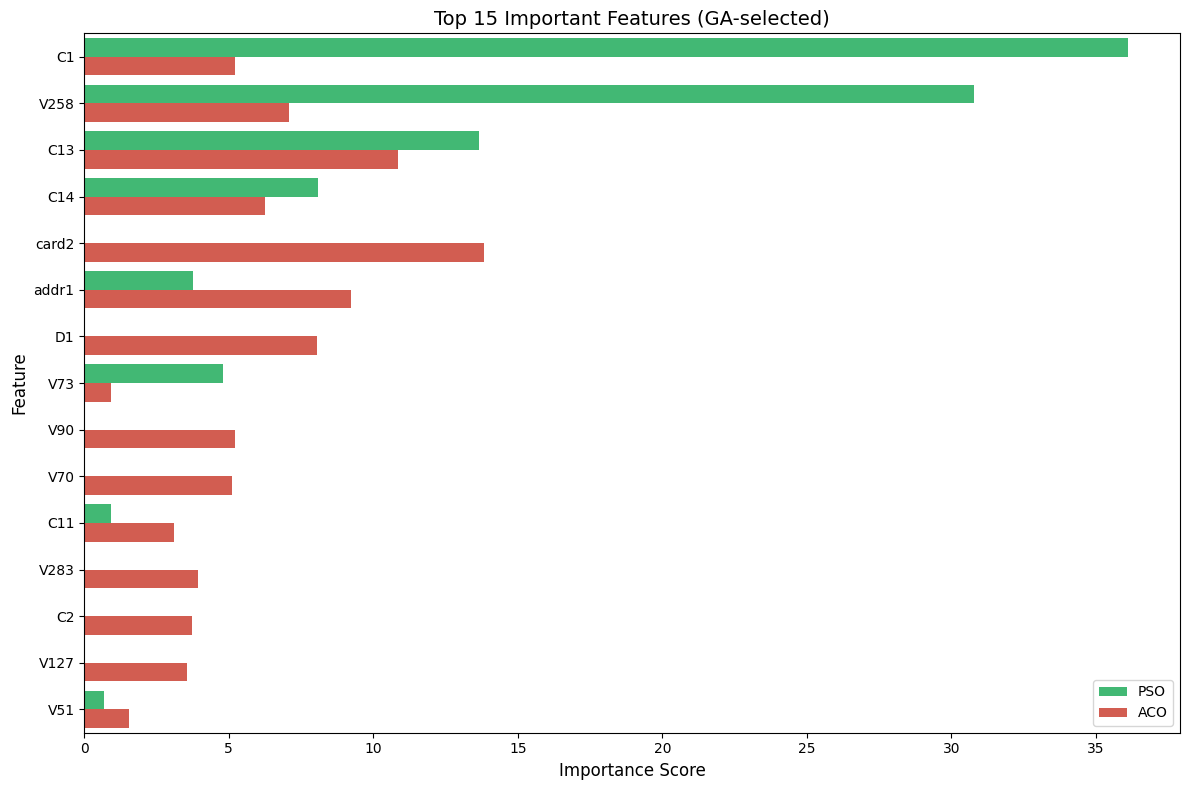


Top 10 Most Important GA-Selected Features:
feature  pso_importance  aco_importance  avg_importance
     C1       36.110276        5.221371       20.665823
   V258       30.788770        7.090108       18.939439
    C13       13.674079       10.858804       12.266442
    C14        8.074633        6.243549        7.159091
  card2        0.000000       13.839367        6.919683
  addr1        3.771990        9.235784        6.503887
     D1        0.000000        8.043014        4.021507
    V73        4.783186        0.907691        2.845439
    V90        0.000000        5.204759        2.602379
    V70        0.000000        5.099733        2.549867


In [30]:
import seaborn as sns
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': X_train_ga.columns,
    'pso_importance': final_model_pso.get_feature_importance(),
    'aco_importance': final_model_aco.get_feature_importance()
})

# Sort by average importance
feature_importance['avg_importance'] = (feature_importance['pso_importance'] + feature_importance['aco_importance']) / 2
feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

# Reshape for seaborn
plot_data = pd.melt(
    feature_importance, 
    id_vars=['feature'], 
    value_vars=['pso_importance', 'aco_importance'],
    var_name='model', 
    value_name='importance'
)
plot_data['model'] = plot_data['model'].map({'pso_importance': 'PSO', 'aco_importance': 'ACO'})

# Top 15 features
top_features = feature_importance.head(15)['feature'].tolist()
plot_data_top = plot_data[plot_data['feature'].isin(top_features)]

# Plot
sns.barplot(
    data=plot_data_top, 
    x='importance', 
    y='feature', 
    hue='model',
    palette=['#2ecc71', '#e74c3c']
)
plt.title('Top 15 Important Features (GA-selected)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='')
plt.tight_layout()
plt.show()

# Print the top features and their importance scores
print("\nTop 10 Most Important GA-Selected Features:")
print(feature_importance[['feature', 'pso_importance', 'aco_importance', 'avg_importance']].head(10).to_string(index=False))

### Compare PSO, ACO, and baseline results on GA-selected features

Now we'll do a comprehensive comparison of all three approaches: baseline CatBoost, PSO-optimized CatBoost, and ACO-optimized CatBoost, all using the same GA-selected features.

Training Baseline CatBoost model on GA-selected features...
0:	test: 0.8188631	best: 0.8188631 (0)	total: 35.1ms	remaining: 17.5s
100:	test: 0.8891202	best: 0.8891202 (100)	total: 3.17s	remaining: 12.5s
200:	test: 0.9063846	best: 0.9063846 (200)	total: 6.27s	remaining: 9.33s
300:	test: 0.9153780	best: 0.9153780 (300)	total: 9.38s	remaining: 6.2s
400:	test: 0.9217532	best: 0.9217532 (400)	total: 12.3s	remaining: 3.04s
499:	test: 0.9259349	best: 0.9259349 (499)	total: 15.3s	remaining: 0us

bestTest = 0.9259348902
bestIteration = 499

Baseline model training finished.

**Validation ROC AUC Scores on GA-Selected Features:**
**Baseline CatBoost:** 0.925935
**PSO-Optimized CatBoost:** 0.746561
**ACO-Optimized CatBoost:** 0.933243


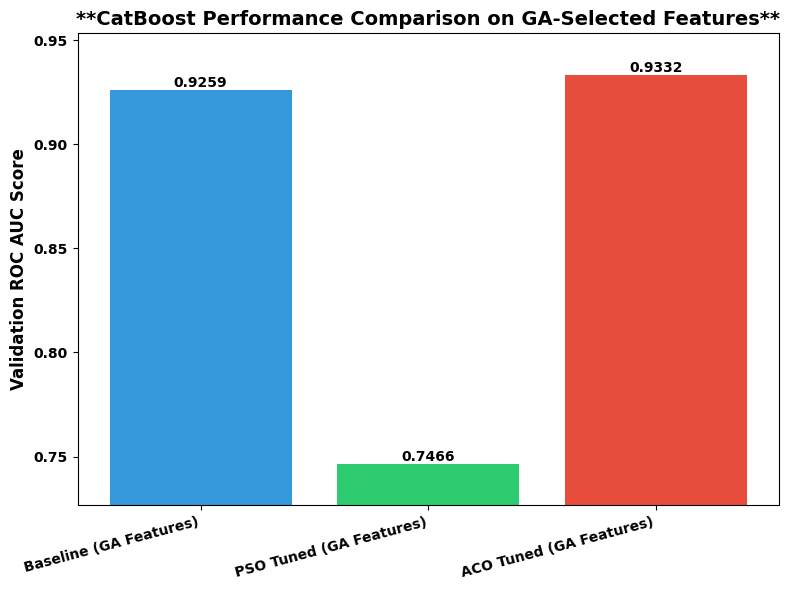

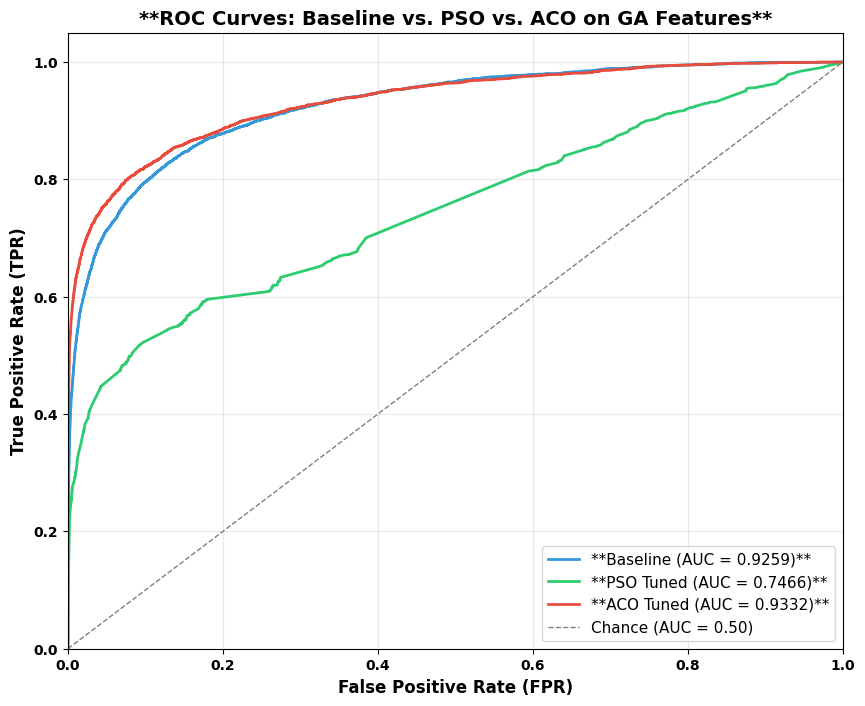

In [33]:
from sklearn.metrics import roc_curve

# 1. Train the Baseline CatBoost model on GA-selected features
print("Training Baseline CatBoost model on GA-selected features...")
baseline_model_ga = CatBoostClassifier(
    iterations=500,          # Using the same iterations as initial baseline tests
    learning_rate=0.1,       # Default learning rate used before
    depth=6,                 # Default depth used before
    class_weights=class_weights_dict,
    random_seed=42,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100              # Show progress
)

baseline_model_ga.fit(
    X_train_ga, y_train,
    eval_set=(X_val_ga, y_val),
    early_stopping_rounds=50, # Use early stopping like the others
    verbose=100
)
print("Baseline model training finished.")

# 2. Make predictions on the validation set for all models
y_pred_baseline_ga = baseline_model_ga.predict_proba(X_val_ga)[:, 1]
y_pred_pso_ga = final_model_pso.predict_proba(X_val_ga)[:, 1]
y_pred_aco_ga = final_model_aco.predict_proba(X_val_ga)[:, 1]

# 3. Calculate ROC AUC scores
auc_baseline_ga = roc_auc_score(y_val, y_pred_baseline_ga)
auc_pso_ga = roc_auc_score(y_val, y_pred_pso_ga)
auc_aco_ga = roc_auc_score(y_val, y_pred_aco_ga)

print(f"\n**Validation ROC AUC Scores on GA-Selected Features:**")
print(f"**Baseline CatBoost:** {auc_baseline_ga:.6f}")
print(f"**PSO-Optimized CatBoost:** {auc_pso_ga:.6f}")
print(f"**ACO-Optimized CatBoost:** {auc_aco_ga:.6f}")

# 4. Create Bar Plot for ROC AUC Scores
plt.figure(figsize=(8, 6))
models = ['Baseline (GA Features)', 'PSO Tuned (GA Features)', 'ACO Tuned (GA Features)']
scores = [auc_baseline_ga, auc_pso_ga, auc_aco_ga]
colors = ['#3498db', '#2ecc71', '#e74c3c'] # Blue, Green, Red

bars = plt.bar(models, scores, color=colors)
plt.ylabel('Validation ROC AUC Score', fontsize=12, fontweight='bold')
plt.title('**CatBoost Performance Comparison on GA-Selected Features**', fontsize=14, fontweight='bold')
plt.ylim(min(scores) - 0.02, max(scores) + 0.02) # Adjust y-axis limits
plt.xticks(rotation=15, ha='right', fontsize=10, fontweight='bold')
plt.yticks(fontweight='bold')

# Add score labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontweight='bold') # va: vertical alignment

plt.tight_layout()
plt.show()

# 5. Calculate ROC Curve data
fpr_base_ga, tpr_base_ga, _ = roc_curve(y_val, y_pred_baseline_ga)
fpr_pso_ga, tpr_pso_ga, _ = roc_curve(y_val, y_pred_pso_ga)
fpr_aco_ga, tpr_aco_ga, _ = roc_curve(y_val, y_pred_aco_ga)

# 6. Create ROC Curve Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_base_ga, tpr_base_ga, color='#3498db', lw=2, label=f'**Baseline (AUC = {auc_baseline_ga:.4f})**')
plt.plot(fpr_pso_ga, tpr_pso_ga, color='#2ecc71', lw=2, label=f'**PSO Tuned (AUC = {auc_pso_ga:.4f})**')
plt.plot(fpr_aco_ga, tpr_aco_ga, color='#e74c3c', lw=2, label=f'**ACO Tuned (AUC = {auc_aco_ga:.4f})**')

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Chance (AUC = 0.50)') # Random guess line

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
plt.title('**ROC Curves: Baseline vs. PSO vs. ACO on GA Features**', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11, title_fontproperties={'weight':'bold'}, facecolor='white', framealpha=0.8)
plt.grid(alpha=0.3)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

In conclusion, ACO and PSO provided the same results for the CatBoost in Kaggle, but with validation results much higher, possibly due to overfitting.

In [ ]:
# Use the tuned ACO model
y_pred_catboost_ga_aco = final_model_aco.predict_proba(X_test_ga)
fraud_probs = y_pred_catboost_ga_aco[:, 1]

submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/catboost_ga_aco.csv', index=False)